In [ ]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device('cuda')

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#'
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 15
TIME_MASK = 20

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 64
EPOCHS = 70
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.00001

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

all_chars = Counter(''.join(train_data['message']))
BLANK_CHAR = '_'
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDataset(Dataset):
    '''
    Класс для обработки 
    '''
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, target, target_len, message
            else:
                return augmented_spectrogram, None, None, None
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 1
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # [B, C, 1, 1]
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction),  # [B, C/reduction]
            nn.GELU(),
            nn.Linear(channels // reduction, channels),  # [B, C]
            nn.Sigmoid()
        )
    
    def forward(self, x):
        B, C, _, _ = x.shape
        squeezed = self.squeeze(x).view(B, C)  # [B, C]
        weights = self.excitation(squeezed).view(B, C, 1, 1)  # [B, C, 1, 1]
        return x * weights  # Масштабируем каналы
    
class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # start - [1, 128, 356]
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            SEBlock(FIRST_FE_COUNT),
            nn.MaxPool2d(kernel_size=2, stride=2), # [batch, FIRST_FE_COUNT = 16, 64, 178]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            SEBlock(SECOND_FE_COUNT),
            # nn.MaxPool2d(2, 2), #

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            SEBlock(THIRD_FE_COUNT),
            # nn.MaxPool2d((2, 2), (2, 2)), 

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            # SEBlock(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # [batch=32, QAD_FE_COUNT = 32, 32, 89]
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f'CNN размерность выхода: {cnn_out.shape}'); 
        print(f'CNN число фичей: {self.cnn_output_features}')

        # Добавлен лоейный слой и функция активации. Для чего? расписать потом 
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2, bias=False); 
        self.gelu = nn.GELU()
        self.rnn = nn.LSTM(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=2,
                bidirectional=True,
                dropout=0.3,
                batch_first=True 
            )

        
        self.embed_dim = GRU_HIDEN * 2
        self.layer_norm = nn.LayerNorm(self.embed_dim)      
        self.dropout = nn.Dropout(0.5)   
        self.layer2 = nn.Linear(self.embed_dim, num_classes)       
    

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)

        self.rnn.flatten_parameters()

        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний
        x = self.layer_norm(x)
        x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        # '''
        return x
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    # v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)


def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)

    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[1] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[2] for item in batch])
        msg = [item[3] for item in batch]
        
        return [spectrograms_padded, target, label_len, msg]
    else: 
        return spectrograms_padded

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)

test, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_target, __, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DIVICE)
# model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)  # Было 0.002
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}')

CNN размерность выхода: torch.Size([1, 32, 32, 89])
CNN число фичей: 1024

MorseNet - инициалицация модели. Число обучаемых параметров: 2,939,778


In [2]:
next(iter(test)).shape

torch.Size([1, 128, 356])

# Обучение модели

In [ ]:
lst_loss_train = []
lst_loss_val = []
best_val_loss = 0
for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    train_predicts = []

    train_tqdm = tqdm(train_dl, desc=f'Эпоха {epoch+1}/{EPOCHS} [Обучение]', leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, targets, targets_lens, _ = batch
        mel_spec, targets, targets_lens = mel_spec.to(DIVICE), targets.to(DIVICE), targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue

        if torch.isnan(loss) or torch.isinf(loss): 
            print(f'\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}'); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    total_train = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    total_val = 0
    val_predicts = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f'Эпоха {epoch+1}/{EPOCHS} [Валидация]', 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

    total_val = val_loss / len(val_dl)

    lst_loss_train.append(total_train)
    lst_loss_val.append(total_val)

    scheduler.step(total_val)

    print(f'\n===== Эпоха {epoch+1}/{EPOCHS} =====')\
    #===== Инфо про градиенты=====
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f'Mean grad norm: {np.mean(grad_norms):.6f}')
        print(f'Max grad norm: {np.max(grad_norms):.6f}')
        print(f'Min grad norm: {np.min(grad_norms):.6f}')
    else:
        print('No gradients computed yet.')
    #===== Инфо про шаг обучения и данные по потерям =====
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current LR: {current_lr:.6f}')
    print(f'---- Train Loss: {total_train:.4f}')
    print(f'---- Val Loss: {total_val:.4f}')
    if current_lr <= 1e-6:
        print('Learning rate достиг минимума 1e-6, остановка обучения')
        break
    print('-' * 50)


===== Эпоха 1/70 =====
Mean grad norm: 0.067728
Max grad norm: 0.627811
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 3.4459
---- Val Loss: 1.1578
--------------------------------------------------



===== Эпоха 2/70 =====
Mean grad norm: 0.057049
Max grad norm: 0.671087
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.7479
---- Val Loss: 0.3471
--------------------------------------------------



===== Эпоха 3/70 =====
Mean grad norm: 0.063624
Max grad norm: 0.696028
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.5143
---- Val Loss: 0.2498
--------------------------------------------------



===== Эпоха 4/70 =====
Mean grad norm: 0.069919
Max grad norm: 0.565835
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.4345
---- Val Loss: 0.2217
--------------------------------------------------



===== Эпоха 5/70 =====
Mean grad norm: 0.066804
Max grad norm: 0.688251
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.3921
---- Val Loss: 0.2525
--------------------------------------------------



===== Эпоха 6/70 =====
Mean grad norm: 0.065438
Max grad norm: 0.703019
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.3618
---- Val Loss: 0.1968
--------------------------------------------------



===== Эпоха 7/70 =====
Mean grad norm: 0.070321
Max grad norm: 0.641522
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.3437
---- Val Loss: 0.2088
--------------------------------------------------



===== Эпоха 8/70 =====
Mean grad norm: 0.073640
Max grad norm: 0.547426
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.3319
---- Val Loss: 0.1652
--------------------------------------------------



===== Эпоха 9/70 =====
Mean grad norm: 0.075331
Max grad norm: 0.589363
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.3134
---- Val Loss: 0.1618
--------------------------------------------------



===== Эпоха 10/70 =====
Mean grad norm: 0.074738
Max grad norm: 0.552752
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.3009
---- Val Loss: 0.1675
--------------------------------------------------



===== Эпоха 11/70 =====
Mean grad norm: 0.062511
Max grad norm: 0.360322
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2884
---- Val Loss: 0.1505
--------------------------------------------------



===== Эпоха 12/70 =====
Mean grad norm: 0.052764
Max grad norm: 0.361552
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2809
---- Val Loss: 0.1615
--------------------------------------------------



===== Эпоха 13/70 =====
Mean grad norm: 0.059757
Max grad norm: 0.804557
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2770
---- Val Loss: 0.1513
--------------------------------------------------



===== Эпоха 14/70 =====
Mean grad norm: 0.063033
Max grad norm: 0.400451
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2729
---- Val Loss: 0.1494
--------------------------------------------------



===== Эпоха 15/70 =====
Mean grad norm: 0.080952
Max grad norm: 0.603744
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2654
---- Val Loss: 0.1576
--------------------------------------------------



===== Эпоха 16/70 =====
Mean grad norm: 0.076044
Max grad norm: 0.532180
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2567
---- Val Loss: 0.1477
--------------------------------------------------



===== Эпоха 17/70 =====
Mean grad norm: 0.071414
Max grad norm: 0.704624
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2517
---- Val Loss: 0.1517
--------------------------------------------------



===== Эпоха 18/70 =====
Mean grad norm: 0.070031
Max grad norm: 0.488423
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2522
---- Val Loss: 0.1394
--------------------------------------------------



===== Эпоха 19/70 =====
Mean grad norm: 0.061508
Max grad norm: 0.369924
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2434
---- Val Loss: 0.1362
--------------------------------------------------



===== Эпоха 20/70 =====
Mean grad norm: 0.066800
Max grad norm: 0.649132
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2409
---- Val Loss: 0.1386
--------------------------------------------------



===== Эпоха 21/70 =====
Mean grad norm: 0.072841
Max grad norm: 0.728541
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2350
---- Val Loss: 0.1458
--------------------------------------------------



===== Эпоха 22/70 =====
Mean grad norm: 0.049989
Max grad norm: 0.287582
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 0.2327
---- Val Loss: 0.1454
--------------------------------------------------



===== Эпоха 23/70 =====
Mean grad norm: 0.075500
Max grad norm: 0.609054
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.2297
---- Val Loss: 0.1397
--------------------------------------------------



===== Эпоха 24/70 =====
Mean grad norm: 0.075838
Max grad norm: 0.613378
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.2062
---- Val Loss: 0.1422
--------------------------------------------------



===== Эпоха 25/70 =====
Mean grad norm: 0.040971
Max grad norm: 0.261296
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1968
---- Val Loss: 0.1317
--------------------------------------------------



===== Эпоха 26/70 =====
Mean grad norm: 0.055147
Max grad norm: 0.539284
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1955
---- Val Loss: 0.1394
--------------------------------------------------



===== Эпоха 27/70 =====
Mean grad norm: 0.049105
Max grad norm: 0.375488
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1916
---- Val Loss: 0.1367
--------------------------------------------------



===== Эпоха 28/70 =====
Mean grad norm: 0.063528
Max grad norm: 0.653781
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 0.1880
---- Val Loss: 0.1411
--------------------------------------------------



===== Эпоха 29/70 =====
Mean grad norm: 0.051385
Max grad norm: 0.362836
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1880
---- Val Loss: 0.1417
--------------------------------------------------



===== Эпоха 30/70 =====
Mean grad norm: 0.038507
Max grad norm: 0.342610
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1760
---- Val Loss: 0.1427
--------------------------------------------------



===== Эпоха 31/70 =====
Mean grad norm: 0.063998
Max grad norm: 0.375559
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1724
---- Val Loss: 0.1459
--------------------------------------------------



===== Эпоха 32/70 =====
Mean grad norm: 0.073506
Max grad norm: 0.698338
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 0.1697
---- Val Loss: 0.1452
--------------------------------------------------



===== Эпоха 33/70 =====
Mean grad norm: 0.036305
Max grad norm: 0.279655
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1656
---- Val Loss: 0.1468
--------------------------------------------------



===== Эпоха 34/70 =====
Mean grad norm: 0.031936
Max grad norm: 0.149740
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1589
---- Val Loss: 0.1463
--------------------------------------------------



===== Эпоха 35/70 =====
Mean grad norm: 0.084062
Max grad norm: 0.519938
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1608
---- Val Loss: 0.1461
--------------------------------------------------



===== Эпоха 36/70 =====
Mean grad norm: 0.032296
Max grad norm: 0.184899
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 0.1562
---- Val Loss: 0.1491
--------------------------------------------------



===== Эпоха 37/70 =====
Mean grad norm: 0.056374
Max grad norm: 0.355176
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1558
---- Val Loss: 0.1503
--------------------------------------------------



===== Эпоха 38/70 =====
Mean grad norm: 0.041048
Max grad norm: 0.298149
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1565
---- Val Loss: 0.1504
--------------------------------------------------



===== Эпоха 39/70 =====
Mean grad norm: 0.079500
Max grad norm: 0.577579
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1556
---- Val Loss: 0.1487
--------------------------------------------------



===== Эпоха 40/70 =====
Mean grad norm: 0.047452
Max grad norm: 0.341132
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 0.1523
---- Val Loss: 0.1501
--------------------------------------------------



===== Эпоха 41/70 =====
Mean grad norm: 0.050903
Max grad norm: 0.286214
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1527
---- Val Loss: 0.1510
--------------------------------------------------



===== Эпоха 42/70 =====
Mean grad norm: 0.060630
Max grad norm: 0.390849
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1483
---- Val Loss: 0.1546
--------------------------------------------------



===== Эпоха 43/70 =====
Mean grad norm: 0.044094
Max grad norm: 0.321819
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 0.1527
---- Val Loss: 0.1529
--------------------------------------------------


KeyboardInterrupt: 

In [5]:
torch.save(model.state_dict(), 'MorseNet.pth')

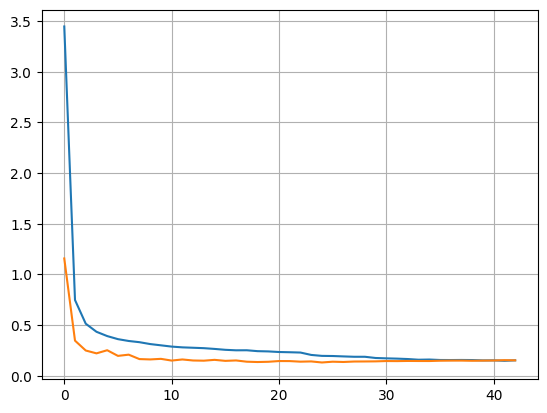

In [6]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [ ]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu()
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy()

    for ind in max_inds:
        merged_inds = []
        prev_idx = None
        for idx in ind:
            if idx != blank_label_idx and idx != prev_idx:
                merged_inds.append(idx)
            prev_idx = idx
        text = ''.join([int_char_map.get(i, '') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq, test_target, _, mess = loader
        train_mess.extend(mess)

        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        logits= model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f'Mean accurasu by The Levenshtein in train is : {mean_acc_test}')
print(f'Mean accurasu by The Levenshtein in validate is : {mean_acc_val}')
print(f'Kagle accurasy: {1 - np.mean(mean_acc_val+mean_acc_test)}')


test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)


test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq = loader
        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 32, 32, 89])
CNN число фичей: 1024
Mean accurasu by The Levenshtein in train is : 0.9560291829189195
Mean accurasu by The Levenshtein in validate is : 0.9710400257135271
Kagle accurasy: -0.9270692086324466
